Data loaded: (128230, 50)
Feature matrix shape: (128230, 43)
Train size: (102584, 43)
Test size: (25646, 43)
Training XGBoost...

📊 Model Performance
----------------------
MAE  : 40.46
RMSE : 135.53

🔝 Top 10 Important Features
aqi_rollmean_24    0.092325
aqi_lag_1          0.053552
aqi_rollmean_6     0.048733
lat                0.040560
pm10_rollmean_6    0.035037
location_id        0.034400
pm10_lag_1         0.032409
nox                0.030792
pm10               0.030253
o3_lag_1           0.028721
dtype: float32


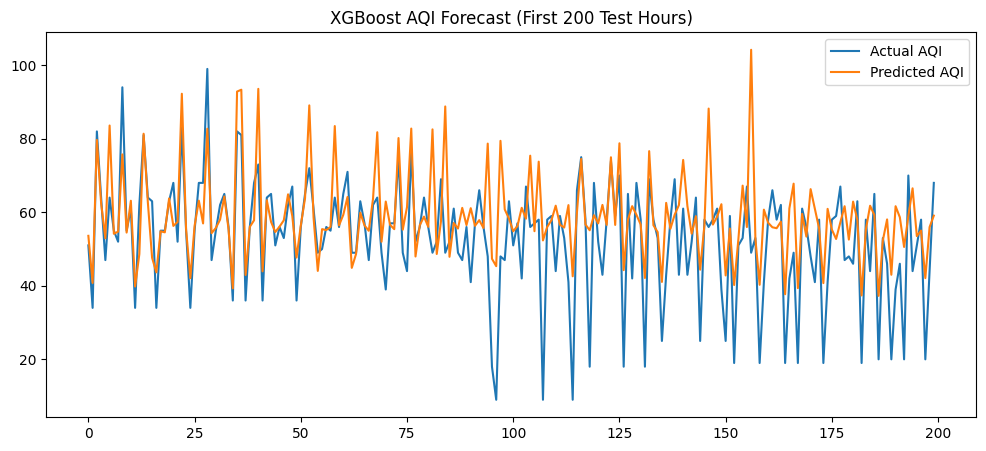

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# ==============================
# 1. LOAD DATA
# ==============================
df = pd.read_csv("kerala.csv", low_memory=False)

# Ensure datetime is correct
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

# Drop rows where target is missing
df = df.dropna(subset=['target_aqi_next_day'])

print("Data loaded:", df.shape)

# ==============================
# 2. DEFINE FEATURES & TARGET
# ==============================
target = 'target_aqi_next_day'

leak_cols = [
    'datetime', 'date', 'time',
    'aqi', 'aqi_category',
    'target_aqi_next_day'
]

X = df.drop(columns=leak_cols, errors='ignore')

# 🔥 CRITICAL FIX: keep only numeric columns
X = X.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])

y = df[target]

print("Feature matrix shape:", X.shape)

# ==============================
# 3. TIME-BASED TRAIN/TEST SPLIT
# ==============================
split_index = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# ==============================
# 4. TRAIN XGBOOST
# ==============================
xgb_model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost...")
xgb_model.fit(X_train, y_train)

# ==============================
# 5. EVALUATE MODEL
# ==============================
preds = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("\n📊 Model Performance")
print("----------------------")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")

# ==============================
# 6. FEATURE IMPORTANCE
# ==============================
importance = pd.Series(xgb_model.feature_importances_, index=X.columns)
importance = importance.sort_values(ascending=False)

print("\n🔝 Top 10 Important Features")
print(importance.head(10))

# ==============================
# 7. PLOT PREDICTIONS VS ACTUAL
# ==============================
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label="Actual AQI")
plt.plot(preds[:200], label="Predicted AQI")
plt.legend()
plt.title("XGBoost AQI Forecast (First 200 Test Hours)")
plt.show()

In [3]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=-1,          # Let LightGBM choose
    num_leaves=64,         # Controls complexity
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=20,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

print("Training LightGBM...")
lgb_model.fit(X_train, y_train)

preds = lgb_model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("\n📊 LightGBM Performance")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")


Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9188
[LightGBM] [Info] Number of data points in the train set: 102584, number of used features: 43
[LightGBM] [Info] Start training from score 56.159430

📊 LightGBM Performance
MAE  : 43.86
RMSE : 161.84


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 1. Load the data
df = pd.read_csv("kerala_aqi_training_ready.csv")

# 2. Select features and target
# We exclude non-numeric/identifier columns like city and datetime
features = [
 'co', 'no', 'no2', 'nox', 'o3',
 'pm10', 'pm25', 'so2',
 'temperature', 'relativehumidity',
 'wind_speed', 'wind_direction',
 'hour', 'day_of_week', 'month',
 'aqi_lag_1', 'aqi_lag_2'
]

target = 'target_next_hour_aqi'

# Remove rows with missing values in the selected features
data = df[features + [target]].dropna()

X = data[features]
y = data[target]

# 3. Split the data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Initialize and Train XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# 5. Initialize and Train LightGBM
lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

# 6. Evaluate Models
def print_metrics(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> RMSE: {rmse:.4f}, R2 Score: {r2:.4f}")
    print(f"{name} -> MAE: {mae:.4f}")

print_metrics("XGBoost", y_test, y_pred_xgb)
print_metrics("LightGBM", y_test, y_pred_lgb)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3606
[LightGBM] [Info] Number of data points in the train set: 9301, number of used features: 17
[LightGBM] [Info] Start training from score 82.046840
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [3]:
importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

             Feature  Importance
6               pm25    0.814616
5               pm10    0.047784
12              hour    0.012173
16         aqi_lag_2    0.011922
9   relativehumidity    0.010641
8        temperature    0.010186
4                 o3    0.010018
10        wind_speed    0.009613
3                nox    0.009558
15         aqi_lag_1    0.009311
13       day_of_week    0.008837
2                no2    0.008413
7                so2    0.008156
1                 no    0.008125
11    wind_direction    0.007938
14             month    0.006386
0                 co    0.006323


In [7]:
import joblib
import os


folder_path = r'C:\Users\Fahad\Desktop\my works\Java AP project\AQI-Risk-Assessment\ml\models'
os.makedirs(folder_path, exist_ok=True)

# Define the full file path
file_path = os.path.join(folder_path, 'xgboost_model.pkl')

# Save the model
joblib.dump(xgb_model, file_path)



['C:\\Users\\Fahad\\Desktop\\my works\\Java AP project\\AQI-Risk-Assessment\\ml\\models\\xgboost_model.pkl']

In [8]:
file_path_lgb = os.path.join(folder_path, 'lightgbm_model.pkl')
joblib.dump(lgb_model, file_path_lgb)

['C:\\Users\\Fahad\\Desktop\\my works\\Java AP project\\AQI-Risk-Assessment\\ml\\models\\lightgbm_model.pkl']